https://colab.research.google.com/drive/1CIn4gqPizES5e0q7nxgW19dHlfmn4dde?ouid=112767571335097495278&usp=drive_link

The runtime disconnected but this was the raw code that was used to create the models and train them. Apologies for that!

DISCLAIMER: Some code (for training loop only) is adapted from our own homework 2 so there may be significant similarities.

# Comparing LHSAT, HAT and BigBird models

We worked on the different models seperately. Below is the compiled code.

## Data and Model Prep

### Importing modules, defining device

In [ ]:
#!pip uninstall transformers
#!pip uninstall torch

!pip install evaluate
!pip install transformers
!pip install datasets
!pip install torch

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, BertTokenizer
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

# pytorch libraries
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
import torch.optim as optim
import torchvision.models as models
from torchsummary import summary

import pandas as pd
import time
import numpy as np
import random

from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
from google.colab import data_table

# libaries for Q5
from transformers import BigBirdForSequenceClassification,BigBirdModel
from datasets import load_dataset
import datasets as ds
from torch.utils.data import DataLoader
import evaluate

# For memeory saving
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["max_split_size_mb"]="1024"

random.seed(10)

#Check if GPU is available. The program will run using the GPU if available,
#otherwise will use CPU.
cuda = torch.cuda.is_available()
cuda #returns a Boolean indicating availability of GPU

from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, BertTokenizer
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding, BertTokenizer
from torch.utils.data import DataLoader
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

### Data cleaning and tokenisation

In [ ]:
import re
from datasets import load_dataset
from transformers import default_data_collator

# Load the dataset
dataset = load_dataset("darrow-ai/USClassActions")

dataset['train'] = dataset['train'].select(range(2000))


# Preprocessing steps: removing entries with no target text and map verdicts to labels
dataset = dataset.filter(lambda example: example['target_text'] is not None)
dataset = dataset.map(lambda example: {'labels': 1 if example['verdict'] == 'win' else 0})


# Function that segments the text
def segment_by_number_dot(example):
    # Creating a regular expression pattern
    pattern = re.compile(r'(?<=\d\.)\s')
    # Splitting the text
    segments = pattern.split(example['target_text'])
    # Filtering out any empty segments just in case
    segments = [segment.strip() for segment in segments if segment.strip()]

    example['segments'] = segments
    return example

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3000 [00:00<?, ? examples/s]

Filter:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

In [ ]:
def tokenize_and_combine_segments(examples):
    # This will store the tokenized inputs for all segments
    tokenized_segments = {'input_ids': [], 'attention_mask': [], 'labels': []}

    for i, segments in enumerate(examples['segments']):

        # Tokenize each segment
        for segment in segments:
            tokenized = tokenizer(segment)
            tokenized_segments['input_ids'].append(tokenized['input_ids'])
            tokenized_segments['attention_mask'].append(tokenized['attention_mask'])
            # Each segment inherits the document's label
            tokenized_segments['labels'].append(examples['labels'])

    return tokenized_segments

def tokenize_and_combine_segments1(examples):
    # This will store the tokenized inputs for all segments
    tokenized_segments = {'input_ids': [], 'attention_mask': [], 'labels': []}

    for i, segments in enumerate(examples['segments']):
        input_ids=[]
        mask=[]
        labels=[]
        # Tokenize each segment
        for segment in segments:
            tokenized = tokenizer(segment, truncation=True, max_length=512,padding="max_length")
            input_ids.append(tokenized['input_ids'])
            mask.append(tokenized['attention_mask'])
            # Each segment inherits the document's label
            labels.append(examples['labels'][i])
        tokenized_segments['input_ids'].append(input_ids)
        tokenized_segments['attention_mask'].append(mask)
        tokenized_segments['labels'].append(labels)

    return tokenized_segments

def split_into_n_parts(example, n=4):
    # Get the target text
    text = example['target_text']
    # Calculate the length of each part
    total_length = len(text)
    part_length = total_length // n

    # List to store the starting indices of each part
    cuts = [i * part_length for i in range(1, n)]
    # Adjust each cut point to not cut through words
    cuts = [text.rfind(' ', 0, cut) for cut in cuts]
    # Ensure all cut points are unique and valid
    cuts = [cut if cut != -1 else i * part_length for i, cut in enumerate(cuts, start=1)]

    # Adding the start and end indices
    cuts = [0] + cuts + [total_length]

    # Split the text into n parts
    parts = [text[cuts[i]:cuts[i + 1]].strip() for i in range(n)]

    # Update the example with the new segments
    example['segments'] = parts

    tokenized_segments = {'input_ids': [], 'attention_mask': [], 'labels': []}

    return example


tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased",max_length=512,truncation=True,padding="max_length",return_tensors='pt')

# Apply tokenization to the dataset
dataset = dataset.map(split_into_n_parts)
tokenized_datasets = dataset.map(tokenize_and_combine_segments1, batched=True, remove_columns=dataset["train"].column_names)

# Since now every "example" is a segment, we might end up with a much larger dataset
# Split the tokenized datasets
train_test_split = tokenized_datasets["train"].train_test_split(test_size=0.2, shuffle=False) # Change back the dataset again before you run it
train_dataset = train_test_split["train"].select(range(1000))  # Select a subset for training to fit memory
val_dataset = train_test_split["test"].select(range(250))  # Select a subset for validation

# Convert to PyTorch DataLoader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=False, batch_size=8, collate_fn=default_data_collator)
eval_dataloader = DataLoader(val_dataset, batch_size=8,collate_fn=default_data_collator)

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

Map:   0%|          | 0/1996 [00:00<?, ? examples/s]

In [ ]:
# Tokenizing the dataset
all_tokenized = []
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased",max_length=512,truncation=True,padding="max_length",return_tensors='pt')
for text in dataset['train']['target_text']:
  tokenized = tokenizer(text)
  all_tokenized.append(tokenized)

In [ ]:
# Storing the lengths of the tokens each document
all_lens = []
for i in range(len(all_tokenized)):
  length = len(all_tokenized[i]['input_ids'])
  all_lens.append(length)

### Some EDA

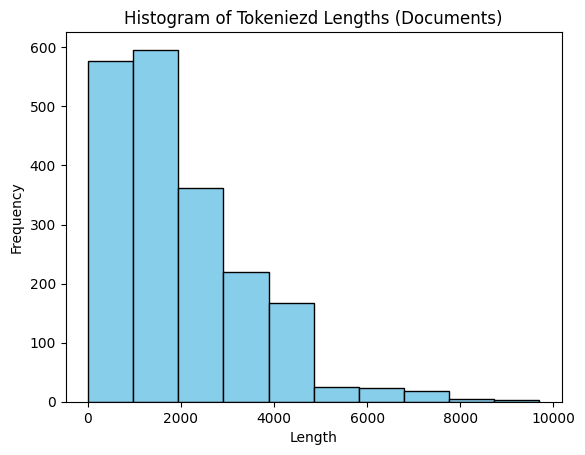

In [ ]:
import matplotlib.pyplot as plt
plt.hist(all_lens, bins=10, color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Tokenized Lengths (Documents)')

# Show plot, histogram of the number of tokens in each document
plt.show()

In [ ]:
# Average token length of train data
sum(all_lens[0:1000])/len(all_lens[0:1000])

1987.571

In [ ]:
# Average token length of test data
sum(all_lens[1600:1850])/len(all_lens[1600:1850])

2084.356

In [ ]:
# Calculating number of tokens greater than 512
total = 0
for x in all_lens:
  if x >= 512:
    total += 1

total/len(all_lens)

0.8847695390781564

## HAT model code

In [ ]:
from transformers import AutoModel
import torch
import torch.nn as nn

from transformers import AutoConfig

# Importing DistilBERT/BigBird for the segment-level transformer
BertModel = AutoModel.from_pretrained("distilbert/distilbert-base-uncased",num_labels=2)
BertConfig = AutoConfig.from_pretrained("distilbert/distilbert-base-uncased",num_labels=2)


# Creating the FNN that will be used for our document-level transformer
num_segments = 4

class NN(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(768*num_segments,256)
    self.fc2 = nn.Linear(256,64)
    self.fc3 = nn.Linear(64,2)

  def forward(self,x):
    x = torch.nn.functional.tanh(self.fc1(x))
    x = torch.nn.functional.tanh(self.fc2(x))
    x = torch.nn.functional.tanh(self.fc3(x))
    return x

DocModel=NN()

def init_weights(m): # initialising the weights
    """
    Custom parameter initialisation

    parameter:

          m: layers of the model
    """
    if type(m) == nn.Linear:
        nn.init.normal_(tensor=m.weight, mean=0.0,std=0.1)


DocModel.apply(init_weights);

In [ ]:
class CustomHATModel(nn.Module):
    def __init__(self, segment_config, document_config):
        super().__init__()
        # Segment-level transformer (BigBird/DistilBert)
        self.segment_transformer = BertModel
        self.segment_transformer.config=segment_config

        # FNN for document-level representation
        self.document_transformer = DocModel

    # Defining the forward pass
    def forward(self, input_ids, attention_mask=None, labels = None):
        all_segment_embeddings = []
        # Segment-level processing
        for i in range(input_ids.size(1)):
            input_id = input_ids[:, i, :]
            a_mask = attention_mask[:,i,:]

            segment_outputs = self.segment_transformer(input_ids=input_id, attention_mask=a_mask)

            segment_embeddings = segment_outputs.last_hidden_state
            all_segment_embeddings.append(segment_embeddings)

        # Aggregating segment representations (here we simply average them)
        segment_embeddings_mean = []
        for segment_embedding in all_segment_embeddings:
          mean_across_tokens = torch.mean(segment_embedding, dim = 1)
          segment_embeddings_mean.append(mean_across_tokens)


        document_representations = torch.cat(segment_embeddings_mean, dim = 1) # Generating the document representation

        # Document-level processing
        attention_mask = torch.ones_like(document_representations, dtype=torch.long, device = document_representations.device)

        document_outputs = self.document_transformer(document_representations)


        loss = None
        if labels is not None:
            # Calculating cross entropy loss
            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(document_outputs, labels[:, 0])
            return (loss, document_outputs)
        else:
          return document_outputs
        print(loss)

In [ ]:
# Configuration for segment-level processing
segment_config=BertConfig

# Instantiate the custom model with both configurations
model = CustomHATModel(segment_config=segment_config, document_config=document_config)

In [ ]:
torch.cuda.empty_cache()

model_path = 'model.pt'
torch.save(model.state_dict(), model_path)

state_dict = torch.load(model_path,map_location='cpu')
model.load_state_dict(state_dict)

#Check if GPU is available. The program will run using the GPU if available,
# otherwise will use CPU.
cuda = torch.cuda.is_available()
cuda #returns a Boolean indicating availability of GPU

device = torch.device("cuda" if cuda else "cpu")
model.to(device)

CustomHATModel(
  (segment_transformer): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (

### Training code for HAT

In [ ]:
from transformers import get_scheduler

model.to(device)

def train(model,train_dataloader,test_dataloader,batch_size, num_epochs=1,c=2):
    """
    Mostly the same code as above but adapted to the task.

    The loss function is not initialised since the loss is defined in the BigBird model
    configuration.

    Learning-rate scheduling is applied since that was recommended in the original BigBird paper.
    """
    train_loader=train_dataloader
    val_loader = eval_dataloader

    #Initialising optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    num_steps= num_epochs*len(train_dataloader)

    lr_scheduler = get_scheduler("linear",
        optimizer=optimizer,num_warmup_steps=0.1*num_steps,num_training_steps=num_steps)

    train_losses, val_losses = [], []

    n = 0
    start_time = time.time()
    train_size = len(train_loader)
    val_size = len(val_loader)

    iters, losses, train_acc, val_acc = [], [], [], []
    epoch_count=0

    # TRAINING

    for epoch in range(num_epochs):

        epoch_count+=1
        torch.cuda.empty_cache()
        progress = tqdm(total=train_size)

        train_loss = 0
        val_loss = 0

        accumulation_steps = 4

        for batch in train_loader:
            model.train()
            model.zero_grad()

            # transferring the outputs, the attention mask and the labels to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # Forward pass
            model.requires_grad_()
            out = model(**batch)

            loss = out[0]


            if loss!=None:
                    train_loss += loss

            # Backward pass
            loss.backward()

            # Updating and reset
            optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()

            iters.append(n)
            losses.append(float(loss)/batch_size)
            train_acc.append(get_accuracy(model, data=train_loader,train=True,c=c))
            val_acc.append(get_accuracy(model,data=val_loader,train=False,c=c))
            n += 1

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # VALIDATION
            model.eval()

            with torch.no_grad():
              for batch in val_loader:
                # Same protocol as above
                batch = {k: v.to(device) for k, v in batch.items()}
                out = model(**batch)
                loss=out[0]

                val_loss += loss

            progress.update(1)
            torch.cuda.empty_cache()

        train_losses.append(train_loss/train_size)
        val_losses.append(val_loss/val_size)
        end_time = time.time()

        # For debugging: print(train_losses,val_losses,losses,train_acc,val_acc)

        if epoch_count==1:
          train_losses=[tensor.item() for tensor in train_losses]
          val_losses=[tensor.item() for tensor in val_losses]
        else:
          train_losses=[train_losses[:-1]]+[tensor.item() for tensor in [train_losses[-1]]]
          val_losses=[val_losses[:-1]]+[tensor.item() for tensor in [val_losses[-1]]]

        train_acc=train_acc
        val_acc=val_acc
        print(f'Training Loss in epoch {epoch+1}/{num_epochs}: {train_losses[-1]}, Time: {round(end_time - start_time,5)}s')

    # Plotting the results and returning the accuracies

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Validation Error: {}".format(val_losses[-1]))

    plt.title("Training Curve")

    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")

    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")

    plt.legend(loc='best')
    plt.show()

    return [train_acc,val_acc,train_losses,val_losses,iters,losses]

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# Confusion Matrix function
class_labels = ["Lose", "Win"]
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Using matplotlib and seaborn to plot the plots
    plt.figure(figsize = (6, 4))
    sns.heatmap(cm, annot = True, fmt = "d", cmap = "PuBuGn", xticklabels = labels, yticklabels = labels)

    # Labelling
    plt.xlabel('Predicted classes')
    plt.ylabel('True classes')
    plt.title('Confusion Matrix')

    # Adding the accuracy
    plt.text(0.14, 1.15, f'Error: {1 - accuracy:.2f}', ha = 'center', transform = plt.gca().transAxes, fontsize = 14)

    plt.show()

In [ ]:
def get_accuracy(model,data,train=False,c =2):
    """
    Computes the accuracy via the evaluation library
    """
    model.eval()
    metric = evaluate.load("accuracy")

    for batch in data:
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs[1]
        predictions = torch.argmax(logits, dim=-1)
        references=batch["labels"][:, 0]

        metric.add_batch(predictions=predictions, references=references)

    accuracy=metric.compute()

    # For Debugging
    #plot_confusion_matrix(references.cpu(), predictions.cpu(), ["Lose", "Win"])

    return accuracy['accuracy']

### Running HAT and plotting results

In [ ]:
# Running the training loop
torch.cuda.empty_cache()
num_classes=2

results=train(model, train_dataloader,eval_dataloader,num_epochs=4,
              batch_size=8)


In [ ]:
# Loss Function Plot
plt.plot(results[-1])

In [ ]:
# code to generate the confusion matrix

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


def collect_predictions(model, data_loader, device):
   model.eval()
   predictions, true_labels = [], []


   for batch in data_loader:
       batch = {k: v.to(device) for k, v in batch.items()}
       with torch.no_grad():
           outputs = model(**batch)


       logits = outputs[1]  # Ensure this matches your model's output format
       batch_predictions = torch.argmax(logits, dim=-1).cpu().numpy()
       batch_labels = batch['labels'].cpu().numpy()
       batch_labels = batch_labels[:, 0]


       predictions.extend(batch_predictions)
       true_labels.extend(batch_labels)


   return predictions, true_labels

# Collect predictions and true labels
predictions, true_labels = collect_predictions(model, eval_dataloader, device)

# Compute the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from google.colab import drive
import torch
# Saving the models
drive.mount('/content/drive/')

torch.save(model.state_dict(), '/content/drive/My Drive/model-512-4-fulldata.pth')

In [ ]:
model = CustomHATModel(segment_config=segment_config, document_config=document_config) # Loading back in the models
model.load_state_dict(torch.load('/content/drive/My Drive/model-512-4-fulldata.pth'))
print(model)

## Plain BigBird code

### Training functions

In [ ]:
from transformers import get_scheduler

def train(model,train_dataloader,test_dataloader,batch_size, num_epochs=1):

    train_loader=train_dataloader
    val_loader = eval_dataloader

    #Initialise optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    num_steps= num_epochs*len(train_dataloader)
    lr_scheduler = get_scheduler(
        name="linear",optimizer=optimizer,num_warmup_steps=0.1*num_steps,num_training_steps=num_steps)

    train_losses, val_losses = [], []

    n = 0
    start_time = time.time()
    train_size = len(train_loader)
    val_size = len(val_loader)

    iters, losses, train_acc, val_acc = [], [], [], []
    epoch_count=0

    # TRAINING
    for epoch in range(num_epochs):
        epoch_count+=1
        torch.cuda.empty_cache()
        progress = tqdm(total=train_size)

        train_loss = 0
        val_loss = 0

        for batch in train_loader:
            model.train()
            model.zero_grad()

            # require the outputs, the attention mask and the labels to be transferred to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # labels inconveniently have to be in tensor longform
            batch['labels']=torch.nn.functional.one_hot(batch['labels'],num_classes=2).float()

            # Forward pass
            model.enable_input_require_grads()
            out = model(**batch)
            loss = out.loss
            train_loss += loss

            #Backward pass
            loss.backward()

            # update and reset
            optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()

            iters.append(n)
            losses.append(float(loss)/batch_size)
            train_acc.append(get_accuracy(model, data=train_loader,train=True))
            val_acc.append(get_accuracy(model,data=val_loader,train=False))
            n += 1

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # VALIDATION
            model.eval()

            with torch.no_grad():
              for batch in val_loader:
                # same protocol as above
                batch = {k: v.to(device) for k, v in batch.items()}
                batch['labels']=torch.nn.functional.one_hot(batch['labels'],num_classes=2).float()
                out = model(**batch)
                loss = out.loss
                val_loss += loss

            progress.update(1)
            torch.cuda.empty_cache()

        train_losses.append(train_loss/train_size)
        val_losses.append(val_loss/val_size)
        end_time = time.time()

        # for debugging: print(train_losses,val_losses,losses,train_acc,val_acc)

        if epoch_count==1:
          train_losses=[tensor.item() for tensor in train_losses]
          val_losses=[tensor.item() for tensor in val_losses]
        else:
          train_losses=[train_losses[:-1]]+[tensor.item() for tensor in [train_losses[-1]]]
          val_losses=[val_losses[:-1]]+[tensor.item() for tensor in [val_losses[-1]]]

        train_acc=train_acc
        val_acc=val_acc
        print(f'Training Loss in epoch {epoch+1}/{num_epochs}: {train_losses[-1]}, Time: {round(end_time - start_time,5)}s')

    #Plotting and results

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Validation Error: {}".format(val_losses[-1]))

    plt.title("Training Curve")

    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")

    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")

    plt.legend(loc='best')
    plt.show()

    return [train_acc,val_acc,train_losses,val_losses,iters,losses]

In [ ]:
def get_accuracy(model,data,train=False):

    model.eval()
    metric = evaluate.load("accuracy")

    for batch in data:
        batch = {k: v.to(device) for k, v in batch.items()}
        batch['labels']=torch.nn.functional.one_hot(batch['labels'],num_classes=2).float()
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        references=batch["labels"]

        # have to convert the labels back from longform
        indices = torch.nonzero(references, as_tuple=False)
        references = torch.tensor([[idx.item()] for idx in indices[:, 1]])
        metric.add_batch(predictions=predictions, references=references)

    accuracy=metric.compute()
    return accuracy['accuracy']

### Running BigBird

The confusion matrix and analysis code is the same as for HAT and LHSAT.

  0%|          | 0/143 [00:00<?, ?it/s]

Training Loss in epoch 1/4: 0.6876490712165833, Time: 10422.73314s


  0%|          | 0/143 [00:00<?, ?it/s]

Training Loss in epoch 2/4: 0.6563109159469604, Time: 20851.0951s


  0%|          | 0/143 [00:00<?, ?it/s]

Training Loss in epoch 3/4: 0.6034430861473083, Time: 31266.23064s


  0%|          | 0/143 [00:00<?, ?it/s]

Training Loss in epoch 4/4: 0.5279842019081116, Time: 41677.33306s
Final Training Accuracy: 0.777
Final Validation Accuracy: 0.7
Final Validation Error: 85.91658020019531


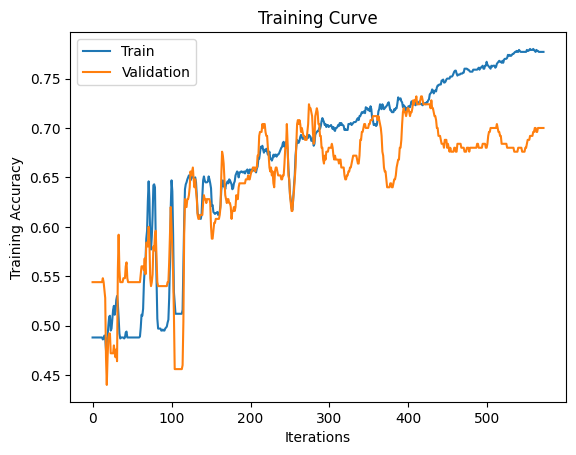

In [ ]:
torch.cuda.empty_cache()
num_classes=2
results=train(model, train_dataloader,eval_dataloader,num_epochs=4,batch_size=7)

## The LHSAT model code

### Creating the LHSAT

In [ ]:
from transformers import AutoModel
import torch
import torch.nn as nn

from transformers import AutoConfig

BigBirdModel = AutoModel.from_pretrained("google/bigbird-roberta-base",num_labels=2,block_size=48)
BigBirdConfig = AutoConfig.from_pretrained("google/bigbird-roberta-base",num_labels=2,block_size=48)

num_segments = 2

class NN(nn.Module):
  def __init__(self):
    super().__init__()

    self.fc1 = nn.Linear(int(768*num_segments),256)
    self.fc2 = nn.Linear(256,64)
    self.fc3 = nn.Linear(64,2)

  def forward(self,x):
    x = torch.nn.functional.tanh(self.fc1(x))
    x = torch.nn.functional.tanh(self.fc2(x))
    x = torch.nn.functional.tanh(self.fc3(x))
    return x

DocModel=NN()

def init_weights(m):

    if type(m) == nn.Linear:
        nn.init.normal_(tensor=m.weight, mean=0.0,std=0.1)


DocModel.apply(init_weights);

config.json:   0%|          | 0.00/760 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/513M [00:00<?, ?B/s]

In [ ]:
class CustomHATModelBigBird(nn.Module):
    def __init__(self, segment_config):
        super().__init__()
        # Each segment is processed by a separate Transformer (BigBird)
        self.segment_transformer = BigBirdModel
        self.segment_transformer.config=segment_config

        # BigBird for cross-segment attention and document-level processing
        self.document_transformer = DocModel


    def forward(self, input_ids, attention_mask=None, labels = None):

        all_segment_embeddings = []
        # Segment-level processing
        for i in range(input_ids.size(1)):
            input_id = input_ids[:, i, :]
            a_mask = attention_mask[:,i,:]

            segment_outputs = self.segment_transformer(input_ids=input_id, attention_mask=a_mask)

            segment_embeddings = segment_outputs.last_hidden_state
            all_segment_embeddings.append(segment_embeddings)

        #final_embedding = None
        segment_embeddings_mean = []
        for segment_embedding in all_segment_embeddings:
          mean_across_tokens = torch.mean(segment_embedding, dim = 1)
          segment_embeddings_mean.append(mean_across_tokens)

        document_representations = torch.cat(segment_embeddings_mean, dim = 1)

        # Document-level processing
        attention_mask = torch.ones_like(document_representations, dtype=torch.long, device = document_representations.device)

        document_outputs = self.document_transformer(document_representations)

        loss = None
        if labels is not None:

            loss_fct = nn.CrossEntropyLoss()
            loss = loss_fct(document_outputs, labels[:, 0])
            return (loss, document_outputs)
        else:
          return document_outputs
        print(loss)

In [ ]:
# Configuration for segment-level processing
segment_config=BigBirdConfig


In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "google/bigbird-roberta-base", num_labels=2
)


torch.cuda.empty_cache()

model_path = 'model.pt'
torch.save(model.state_dict(), model_path)

state_dict = torch.load(model_path,map_location='cpu')
model.load_state_dict(state_dict)

device = torch.device("cuda" if cuda else "cpu")
model.to(device)

Some weights of BigBirdForSequenceClassification were not initialized from the model checkpoint at google/bigbird-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BigBirdForSequenceClassification(
  (bert): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(50358, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [ ]:
torch.cuda.empty_cache()

model_path = 'model.pt'
torch.save(model.state_dict(), model_path)

state_dict = torch.load(model_path,map_location='cpu')
model.load_state_dict(state_dict)

cuda = torch.cuda.is_available()
cuda

device = torch.device("cuda" if cuda else "cpu")
model.to(device)

CustomHATModelBigBird(
  (segment_transformer): BigBirdModel(
    (embeddings): BigBirdEmbeddings(
      (word_embeddings): Embedding(50358, 768, padding_idx=0)
      (position_embeddings): Embedding(4096, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BigBirdEncoder(
      (layer): ModuleList(
        (0-11): 12 x BigBirdLayer(
          (attention): BigBirdAttention(
            (self): BigBirdBlockSparseAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): BigBirdSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine

### Training functions

In [ ]:
from transformers import get_linear_schedule_with_warmup

def train(model,train_dataloader,test_dataloader,batch_size, num_epochs=1,c=2):

    train_loader=train_dataloader
    val_loader = eval_dataloader

    #Initialise optimizer and learning rate scheduler
    optimizer = optim.AdamW(model.parameters(), lr=2e-5)
    num_steps= num_epochs*len(train_dataloader)
    lr_scheduler = get_linear_schedule_with_warmup(
        optimizer=optimizer,num_warmup_steps=0.1*num_steps,num_training_steps=num_steps)

    train_losses, val_losses = [], []

    n = 0
    start_time = time.time()
    train_size = len(train_loader)
    val_size = len(val_loader)

    iters, losses, train_acc, val_acc = [], [], [], []
    epoch_count=0

    # TRAINING

    for epoch in range(num_epochs):

        epoch_count+=1
        torch.cuda.empty_cache()
        progress = tqdm(total=train_size)

        train_loss = 0
        val_loss = 0

        accumulation_steps = 4

        for batch in train_loader:
            model.train()
            model.zero_grad()

            # require the outputs, the attention mask and the labels to be transferred to device
            batch = {k: v.to(device) for k, v in batch.items()}

            # labels inconveniently have to be in tensor longform
            batch['labels']=torch.nn.functional.one_hot(batch['labels'],num_classes=c).float()

            # Forward pass
            model.enable_input_require_grads()
            out = model(**batch)
            loss = out.loss
            train_loss += loss

            #Backward pass
            loss.backward()

            # update and reset
            optimizer.step()
            optimizer.zero_grad()
            lr_scheduler.step()

            iters.append(n)
            losses.append(float(loss)/batch_size)
            train_acc.append(get_accuracy(model, data=train_loader,train=True,c=c))
            val_acc.append(get_accuracy(model,data=val_loader,train=False,c=c))
            n += 1

            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # VALIDATION
            model.eval()

            with torch.no_grad():
              for batch in val_loader:
                # same protocol as above
                batch = {k: v.to(device) for k, v in batch.items()}
                batch['labels']=torch.nn.functional.one_hot(batch['labels'],num_classes=c).float()
                out = model(**batch)
                loss = out.loss
                val_loss += loss

            progress.update(1)
            torch.cuda.empty_cache()

        train_losses.append(train_loss/train_size)
        val_losses.append(val_loss/val_size)
        end_time = time.time()

        # for debugging: print(train_losses,val_losses,losses,train_acc,val_acc)

        if epoch_count==1:
          train_losses=[tensor.item() for tensor in train_losses]
          val_losses=[tensor.item() for tensor in val_losses]
        else:
          train_losses=[train_losses[:-1]]+[tensor.item() for tensor in [train_losses[-1]]]
          val_losses=[val_losses[:-1]]+[tensor.item() for tensor in [val_losses[-1]]]

        train_acc=train_acc
        val_acc=val_acc
        print(f'Training Loss in epoch {epoch+1}/{num_epochs}: {train_losses[-1]}, Time: {round(end_time - start_time,5)}s')

    #Plotting and results

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Final Validation Error: {}".format(val_losses[-1]))

    plt.title("Training Curve")

    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")

    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")

    plt.legend(loc='best')
    plt.show()

    return [train_acc,val_acc,train_losses,val_losses,iters,losses]

In [ ]:
def get_accuracy(model,data,train=False,c=2):

    model.eval()
    metric = evaluate.load("accuracy")

    for batch in data:
        batch = {k: v.to(device) for k, v in batch.items()}
        batch['labels']=torch.nn.functional.one_hot(batch['labels'],num_classes=c).float()
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        references=batch["labels"]

        # have to convert the labels back from longform
        indices = torch.nonzero(references, as_tuple=False)
        references = torch.tensor([[idx.item()] for idx in indices[:, 1]])
        metric.add_batch(predictions=predictions, references=references)

    accuracy=metric.compute()
    return accuracy['accuracy']

### Running the model

In [ ]:
# running training
torch.cuda.empty_cache()
num_classes=2

results=train(model, train_dataloader,eval_dataloader,num_epochs=4,
              batch_size=10)